Import the librairies and modules:

In [78]:
import networkx as nx
import os
import csv
import re
import numpy as np
from BAG_Code_tw520.BayesianAttackGraphForCVSS import parse_dot
from Threat_Inteligence.CWE_tree.parse import parse_xml
from BAG_Code_tw520.BayesianAttackGraphForCVSS import change_prob
from BAG_Code_tw520.createANDtable import create_AND_table
from BAG_Code_tw520.createORtable import create_OR_table

from pgmpy.inference.ExactInference import BeliefPropagation
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD

To prepare the simulation use the following to put the graph in memory:

In [79]:
def parse_dot(dot_string):
    nodes = {}
    edges = []

    # Définir une expression régulière pour extraire les informations de chaque nœud
    # node_pattern = re.compile("(\d+)")
    node_pattern = re.compile(r'\s+(\d+)\s+\[\s*label="([^"]+)"\s+shape="([^"]+)"\s+CVE="([^"]+)"\s*\];')

    # Définir une expression régulière pour extraire les arêtes
    edge_pattern = re.compile(r'\s+(\d+)\s*->\s*(\d+)\s+\[\s+color="[^"]+"\s*\];')

    # Parcourir chaque ligne du texte
    for line in dot_string.split('\n'):
        # Vérifier si la ligne correspond à un nœud
        node_match = node_pattern.match(line)
        # Vérifier si la ligne correspond à une arête
        edge_match = edge_pattern.match(line)
        if node_match:
            node_id = int(node_match.group(1))
            label = node_match.group(2)
            shape = node_match.group(3)
            node_type = 'AND' if shape == "ellipse" else 'OR'
            cveID = node_match.group(4).strip("\'")
            nodes[node_id] = {'label': label, 'type': node_type, 'CVE': cveID}
        elif edge_match:
            source = int(edge_match.group(1))
            target = int(edge_match.group(2))
            edges.append((source, target))
    model = BayesianNetwork(edges)
    # Read the probabilities for each CVE
    cvss_dict = {}
    with open('C:/Users/docuser/Documents/ImperialWork/Threat_Inteligence/epss_scores-2024-04-25.csv', mode='r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            cvss_dict[row['cve']] = row['epss']
    for elem in nodes.items():
        r = elem[1]['type'] == 'OR'
        #We look for the source nodes
        source = []
        probs = []
        for edge in edges:
            if edge[1] == elem[0]:
                source.append(edge[0])
                if elem[1]['CVE'] == "null":
                    # We use the probability associated to the rule if not null
                    tmp = float(elem[1]['label'].split(':')[2])
                    if tmp != 0:
                        print(elem[1]['label'])
                        probs.append(float(tmp))
                    else: 
                        probs.append(0.9999999)
                else:
                    probs.append(float(cvss_dict[elem[1]['CVE']]))
        npa = len(source)
        #We draw the probability from the distribution of CVSS scores
        if r:
            cpt = create_OR_table(probs)
        else:
            cpt = create_AND_table(probs)
        if npa:
            cpd = TabularCPD(elem[0], 2, cpt.T, source, evidence_card=2*np.ones(npa))
        else:
            cpd = TabularCPD(elem[0], 2, cpt.T)
        #Insert the conditional probability table into the Bayesian Network object
        model.add_cpds(cpd)
    return model, edges, nodes


def change_prob(BAG, edges, nodes, cwe_dict, Gcwe, prop0, factor, evidence_loc):
    src_node = set()
    for c_node in evidence_loc:
        src_node.update(get_all_ancestors(BAG, c_node))
    dst_node = set(nodes) - src_node
    for dst_n in dst_node:
        dst_k = dst_n
        dst_cve = nodes[dst_k]['CVE']
        if dst_cve == "null":
            continue
        print(dst_cve)
        dst_cwe = cwe_dict[dst_cve]
        if dst_cwe != 'NVD-CWE-Other' and dst_cwe != "NVD-CWE-noinfo":
            for e in edges:
                if e[1] == dst_k:
                    source = [e[0]]
                    new_prob = BAG.get_cpds(dst_k).values[1][1]
                    for s in src_node:
                        src_k = s
                        src_cve = nodes[src_k]['CVE']
                        if src_cve == "null":
                            continue
                        src_cwe = cwe_dict[src_cve]
                        if src_cwe != 'NVD-CWE-Other' and src_cwe != "NVD-CWE-noinfo":
                            dist = nx.shortest_path_length(Gcwe, source=src_cwe.split('-')[1], target=dst_cwe.split('-')[1])
                            print("CVE source : " + nodes[src_k]['label'])
                            tmp_prob = factor**(dist+1) * prop0.query([src_k],evidence=evidence_loc).values[1]
                            print(222222222222222222222222222222)
                            new_prob = tmp_prob + new_prob - new_prob*tmp_prob
                    props = create_OR_table([new_prob])
                    BAG.remove_cpds(dst_k)
                    BAG.add_cpds(TabularCPD(dst_k, 2, props.T, source, evidence_card=2*np.ones(1)))

def get_all_ancestors(BAG, node, ancestors=set()):
    parents = BAG.get_parents(node)
    ancestors.update(parents)
    for p in parents:
        get_all_ancestors(BAG, p, ancestors)
    return ancestors


In [80]:
# Name of the simulation
simulation = "OCD_pentest"

# Path to the folder containing the tree
path = "C:/Users/docuser/Documents/ImperialWork/Personnal_simulations/output_" + simulation + "/strongly_connected_components/"
file_name = "ag-nocycles.dot"
path_to_dot = path + file_name
output_file = path + file_name[:-4] + "_inference.txt"

# We all read from the file, adding probabilities in the same time
BAG, edges, nodes = parse_dot(open(path_to_dot, 'r').read())

# This is the reference BAG, before the attacker has compromised any node
BAG_ref = BAG.copy()
prop0 = BeliefPropagation(BAG_ref)

# We create a dictionary to get the node number from the label
inverted_nodes = {int(v['label'].split(':')[0]): k for k, v in nodes.items()}

2:RULE 10 (permissions move):0.8
2:RULE 10 (permissions move):0.8
4:RULE 6 (valid credentials may be found):0.8
24:RULE 3 (host may be vulnerable):0.2
45:RULE 5 (low access is possible):0.8


In [81]:
print(BAG.get_cpds(15))

+-------+-------+---------+
| 16    | 16(0) | 16(1)   |
+-------+-------+---------+
| 15(0) | 1.0   | 0.88408 |
+-------+-------+---------+
| 15(1) | 0.0   | 0.11592 |
+-------+-------+---------+


In [82]:
# The skills layer:
cpd_ALskills = TabularCPD('ALskills', 2, [[0], [1]])
cpd_AHskills = TabularCPD('AHskills', 2, [[1], [0]])
cpd_0skills = TabularCPD('0skills', 2, [[0.5], [0.5]])
BAG.add_edge('ALskills', 'Lskills')
BAG.add_edge('ALskills', 'Hskills')
BAG.add_edge('AHskills', 'Hskills')
BAG.add_edge('Hskills', 'Lskills')
cpd_Lskills = TabularCPD('Lskills', 2, create_OR_table([0.9, 1]).T, ['ALskills', 'Hskills'], evidence_card=2*np.ones(2))
cpd_Hskills = TabularCPD('Hskills', 2, create_OR_table([0.1, 0.9]).T, ['ALskills', 'AHskills'], evidence_card=2*np.ones(2))

# The tools layer:
cpd_Aimpacket = TabularCPD('Aimpacket', 2, [[0], [1]])
cpd_Aimpacketplus = TabularCPD('Aimpacket+', 2, [[1], [0]])
BAG.add_edge('Aimpacket', 'impacket+')
BAG.add_edge('Aimpacket', 'impacket')
BAG.add_edge('Aimpacket+', 'impacket+')
BAG.add_edge('impacket+', 'impacket')
cpd_impacket = TabularCPD('impacket', 2, create_OR_table([1, 1]).T, ['Aimpacket', 'impacket+'], evidence_card=2*np.ones(2))
cpd_impacketplus = TabularCPD('impacket+', 2, create_OR_table([0.9, 1]).T, ['Aimpacket', 'Aimpacket+'], evidence_card=2*np.ones(2))
cpd_tools = [TabularCPD(tool, 2, [[0.5], [0.5]]) for tool in ['Metasploit', 'Responder', 'dnscmd.exe', 'certipy']]


# The knowledge layer:
cpd_known_vuln = TabularCPD('Known vulnerabilities', 2, [[0.5], [0.5]])
cpd_cqcm = TabularCPD('CQCM', 2, [[0.5], [0.5]])
cpd_mitm = TabularCPD('MITM', 2, [[0], [1]])

cpt_15 = create_AND_table([1, 1, 1, 1])

# Report sur MS08-M68
BAG.add_edge('Metasploit', 15)
BAG.add_edge('0skills', 15)
BAG.add_edge('MITM', 15)
newlist = BAG.get_parents(15)
BAG.add_cpds(TabularCPD(15, 2, cpt_15.T, newlist , evidence_card=2*np.ones(len(newlist))))
# Report sur CVE-2014-1812
BAG.add_edge('Metasploit', 18)
BAG.add_edge('0skills', 18)
BAG.add_edge('CQCM', 18)
newlist = BAG.get_parents(18)
BAG.add_cpds(TabularCPD(18, 2, cpt_15.T, newlist, evidence_card=2*np.ones(len(newlist))))
# Report sur CVE-2020-1472
BAG.add_edge('impacket+', 20)
BAG.add_edge('Lskills', 20)
BAG.add_edge('CQCM', 20)
newlist = BAG.get_parents(20)
BAG.add_cpds(TabularCPD(20, 2, cpt_15.T, newlist, evidence_card=2*np.ones(len(newlist))))
# Report sur CVE-2021-1675
BAG.add_edge('impacket+', 24)
BAG.add_edge('Lskills', 24)
BAG.add_edge('Known vulnerabilities', 24)
newlist = BAG.get_parents(24)
BAG.add_cpds(TabularCPD(24, 2, cpt_15.T, newlist, evidence_card=2*np.ones(len(newlist))))


BAG.add_cpds(cpd_mitm, cpd_0skills, cpd_cqcm, cpd_impacketplus, cpd_Lskills, cpd_known_vuln, cpd_ALskills, cpd_AHskills, cpd_Hskills, cpd_Aimpacket, cpd_Aimpacketplus, cpd_impacket)
for tool_cpd in cpd_tools:
    if BAG.__contains__(tool_cpd.variable):
        BAG.add_cpds(tool_cpd)

BAG.remove_node(19)
BAG.remove_node(21)
BAG.remove_node(22)
BAG.remove_node(23)
BAG.remove_node(25)
BAG.remove_node(26)
cpt_14 = create_OR_table([1, 1, 1, 1])
BAG.add_cpds(TabularCPD(14, 2, cpt_14.T, [15, 18, 20, 24], evidence_card=2*np.ones(4)))
print(BAG.get_cpds(14))
print(BAG.get_cpds('MITM'))
prop = BeliefPropagation(BAG)
tmp = 14
print(prop.query([tmp]))
print(prop.query([15]))
print(prop.query([18]))
print(prop.query([20]))
print(prop.query([24]))
print(prop0.query([tmp]))

The variable Metasploit already exists in the BAG
+-------+-------+-------+-------+-----+-------+-------+-------+-------+
| 15    | 15(0) | 15(0) | 15(0) | ... | 15(1) | 15(1) | 15(1) | 15(1) |
+-------+-------+-------+-------+-----+-------+-------+-------+-------+
| 18    | 18(0) | 18(0) | 18(0) | ... | 18(1) | 18(1) | 18(1) | 18(1) |
+-------+-------+-------+-------+-----+-------+-------+-------+-------+
| 20    | 20(0) | 20(0) | 20(1) | ... | 20(0) | 20(0) | 20(1) | 20(1) |
+-------+-------+-------+-------+-----+-------+-------+-------+-------+
| 24    | 24(0) | 24(1) | 24(0) | ... | 24(0) | 24(1) | 24(0) | 24(1) |
+-------+-------+-------+-------+-----+-------+-------+-------+-------+
| 14(0) | 1.0   | 0.0   | 0.0   | ... | 0.0   | 0.0   | 0.0   | 0.0   |
+-------+-------+-------+-------+-----+-------+-------+-------+-------+
| 14(1) | 0.0   | 1.0   | 1.0   | ... | 1.0   | 1.0   | 1.0   | 1.0   |
+-------+-------+-------+-------+-----+-------+-------+-------+-------+
+---------+---

c:\Users\docuser\AppData\Local\Programs\Python\Python312\Lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:796: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi1.values


+-------+-----------+
| 14    |   phi(14) |
+=======+===========+
| 14(0) |    0.6019 |
+-------+-----------+
| 14(1) |    0.3981 |
+-------+-----------+
+-------+-----------+
| 15    |   phi(15) |
+=======+===========+
| 15(0) |    0.9500 |
+-------+-----------+
| 15(1) |    0.0500 |
+-------+-----------+
+-------+-----------+
| 18    |   phi(18) |
+=======+===========+
| 18(0) |    0.9750 |
+-------+-----------+
| 18(1) |    0.0250 |
+-------+-----------+
+-------+-----------+
| 20    |   phi(20) |
+=======+===========+
| 20(0) |    0.9181 |
+-------+-----------+
| 20(1) |    0.0819 |
+-------+-----------+
+-------+-----------+
| 24    |   phi(24) |
+=======+===========+
| 24(0) |    0.6724 |
+-------+-----------+
| 24(1) |    0.3276 |
+-------+-----------+
+-------+-----------+
| 14    |   phi(14) |
+=======+===========+
| 14(0) |    0.1601 |
+-------+-----------+
| 14(1) |    0.8399 |
+-------+-----------+


## When the attacker become dcsync and we want to recalculate for domain admin
src_node = [7, 10]
dst_node = [ 14, 16, 12, 2]

In [83]:
honey_pot = set()
get_all_ancestors(BAG_ref, 1, honey_pot)
src_node = set()
for c_node in evidence_loc:
    get_all_ancestors(BAG_ref, c_node, src_node)
honey_pot = honey_pot - src_node
honney_pot = [((BAG.get_cpds(h).values[-1][-1]-BAG_ref.get_cpds(h).values[-1][-1])/BAG_ref.get_cpds(h).values[-1][-1], nodes[h]['CVE'], nodes[h]['label']) for h in honey_pot if nodes[h]['CVE'] != "null"]
print(min(honney_pot, key=lambda x: x[0])[1:3])

NameError: name 'evidence_loc' is not defined

In [ ]:
#We use the pgmpy library to perform the inference
prop = BeliefPropagation(BAG)

cibles = [1]
for cible in cibles:
    print(prop0.query([inverted_nodes[cible]]))
    print(prop0.query([inverted_nodes[cible]], evidence=evidence_loc))
    print(prop.query([inverted_nodes[cible]], evidence=evidence_loc))

+------+----------+
| 1    |   phi(1) |
+======+==========+
| 1(0) |   0.2185 |
+------+----------+
| 1(1) |   0.7815 |
+------+----------+
+------+----------+
| 1    |   phi(1) |
+======+==========+
| 1(0) |   0.0708 |
+------+----------+
| 1(1) |   0.9292 |
+------+----------+
+------+----------+
| 1    |   phi(1) |
+======+==========+
| 1(0) |   0.0488 |
+------+----------+
| 1(1) |   0.9512 |
+------+----------+


In [ ]:
# distance = nx.shortest_path_length(Gcwe, source='119', target='255')
# print("Distance between nodes '1004' and '732':", distance)

# print(BAG.get_cpds(inverted_nodes[7]))
# table = create_OR_table([0.1])
# source = []
# for edge in edges:
#     if edge[1] == inverted_nodes[7]:
#         source.append(edge[0])
# npa = len(source)
# BAG.add_cpds(TabularCPD(inverted_nodes[7], 2, table.T, source, evidence_card=2*np.ones(npa)))
# print(BAG.get_cpds(inverted_nodes[7]))


# output = open(output_file, 'w')
# for node in nodes.items():
#     output.write(f'{nodes[node[0]]["label"]} : {prop.query([node[0]])}\n')

In [ ]:
from pgmpy.factors.discrete import TabularCPD
from pgmpy.models import BayesianNetwork
from pgmpy.inference import BeliefPropagation
bayesian_model = BayesianNetwork([('A', 'B'), ('A', 'C'), ('B', 'D'), ('C', 'D'), ('Imp', 'B'), ('Imp', 'C'), ('PE', 'B'), ('MITM', 'C')])

cpt_a =[[0.1], [0.9]]
cpd_a = TabularCPD('A', 2, [[0], [1]])
cpd_imp = TabularCPD('Imp', 2, cpt_a)
cpd_pe = TabularCPD('PE', 2, [[0], [1]])
cpd_mitm = TabularCPD('MITM', 2, [[0], [1]])
cpt_b = create_AND_table([0.5, 1, 1])
cpd_b = TabularCPD('B', 2, cpt_b.T, ['A', 'PE', 'Imp'], [2, 2, 2])
cpt_c = create_AND_table([0.5, 1, 1])
cpd_c = TabularCPD('C', 2, cpt_c.T, ['A', 'MITM', 'Imp'], [2, 2, 2])
cpt_d = create_OR_table([1, 1])
cpd_d = TabularCPD('D', 2, cpt_d.T, ['B', 'C'], [2, 2])

bayesian_model.add_cpds(cpd_a, cpd_b, cpd_c, cpd_d, cpd_imp, cpd_pe, cpd_mitm)
belief_propagation = BeliefPropagation(bayesian_model)
print(bayesian_model.get_cpds('Imp'))
print(belief_propagation.query(variables=['D'], show_progress=True))

nx.drawing.nx_pydot.write_dot(bayesian_model, 'bayesian_model.dot')


+--------+-----+
| Imp(0) | 0.1 |
+--------+-----+
| Imp(1) | 0.9 |
+--------+-----+
+------+----------+
| D    |   phi(D) |
+======+==========+
| D(0) |   0.3250 |
+------+----------+
| D(1) |   0.6750 |
+------+----------+


StopIteration: 

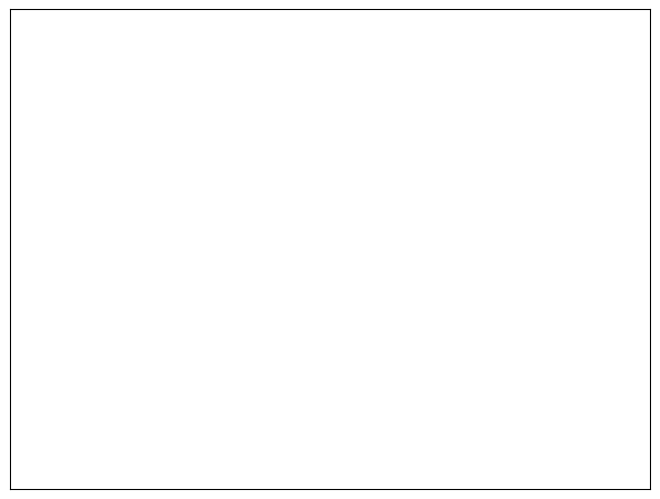